# Twitter Data Scraping

## Business Understanding

In this case, I have to scrape 50 tweets with following requirements:
- containing the keyword "China", and
- limit to Singaporean account.

#### Import module

In [1]:
import json, tweepy, re, string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
from nltk import ngrams

sns.set()

## Data Collection

Token, authentication and API variable preparation. Because I did not get Twitter token from Code for Asia, for a while I will use my friend's token. I named the token "token.json".

In [2]:
with open("token.json")as f:
    tokens = json.load(f)

bearer_token = tokens["bearer_token"]
api_key = tokens["api_key"]
api_key_secret = tokens["api_key_secret"]
access_token = tokens["access_token"]
access_token_secret = tokens["access_token_secret"]

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

Define request parameter variables.

In [3]:
keyword = "china"
place_id = "2509b9adc1fedfd2"   # place_id for Singapore
max_result = 50

Make request to Twitter API.

In [4]:
query = "{} place:{}".format(keyword, place_id)
tweets = tweepy.Cursor(api.search_tweets,
                       q=query,
                       lang="en",   # only get english tweets
                      ).items(max_result)

Save request/scrape result to a Dataframe.

In [5]:
items = []
for tweet in tweets:
    items.append([tweet.created_at, tweet.text])

df = pd.DataFrame(data=items, columns=["Created At", "Tweet"])
df

,Created At,Tweet
0,2022-02-05 12:39:16+00:00,Long live world peace!\n\n Why Putin's visit t...
1,2022-02-05 03:12:36+00:00,I think politics is a big reason too.\nChina t...
2,2022-02-04 14:31:38+00:00,P3...\n The US should know that its allies in ...
3,2022-02-04 14:25:52+00:00,"Asia is Asian!\n\n US President Joe Biden, who..."
4,2022-02-04 05:44:37+00:00,"In mainland China, online MeToo posts were slo..."
5,2022-02-04 02:23:20+00:00,@rupagulab Coz he maybe popular amongst the gu...
6,2022-02-03 23:56:25+00:00,It's not like China when govt has power to cha...
7,2022-02-03 23:06:10+00:00,I really dislike China ppl asking me for direc...
8,2022-02-03 18:03:25+00:00,Important distinction: imperial China had a tr...
9,2022-02-03 15:45:53+00:00,We love Jacky China 🇨🇳 https://t.co/AQFXz4pYqW


Keep in mind that API.search_tweets only able to get tweets maximum 1 week before today. That is why we only got tweets until 28 January 2022. We need premium token to request tweets without time limited.

## Data Preparation

In order for this data to be analyzed, it is necessary to preprocess the data.

#### Text Preprocessing

Define text preprocessing functions:
- Case folding, used to convert text to lowercase and remove numbers, special characters, and punctuation.
- Slang cleaner, used to standardize slang words and remove inappropriate words (harsh, dirty, etc.)
- Stopword cleaner, used to remove common words.

In [6]:
def case_folding(data):
    data = data.lower()
    data = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", data).split())
    data = re.sub(r"\d+", "", data)
    data = data.translate(str.maketrans("", "", string.punctuation))
    data = re.sub(r"\n", "", data)
    data = re.sub(r"\t", "", data)
    return data

def slang_cleaner(data, slang_list):
    word_token = word_tokenize(data)
    slang_list.fillna("", inplace=True)
    slang_list = list(slang_list.itertuples(index=False, name=None))
    word_list = []
    for word in word_token:
        for slang in slang_list:
            if word in slang[0].lower():
                word = slang[1]
                break
        word_list.append(word)
    data = " ".join(word_list)
    return data
    
def stopword_cleaner(data):
    word_token = word_tokenize(data)
    sw_eng = stopwords.words("english")
    data  = [word for word in word_token if word not in sw_eng]
    data = ' '.join(data)
    return data

Now we preprocess our data.

In [7]:
slang = pd.DataFrame([["dun", "do not"]])   # we can add more slang words

df["Tweet_clean"] = ""
df["Tweet_clean"] = df["Tweet"].apply(lambda item: case_folding(item))
df["Tweet_clean"] = df["Tweet_clean"].apply(lambda item: slang_cleaner(item, slang))
df["Tweet_clean"] = df["Tweet_clean"].apply(lambda item: stopword_cleaner(item))
df.head()

,Created At,Tweet,Tweet_clean
0,2022-02-05 12:39:16+00:00,Long live world peace!\n\n Why Putin's visit t...,long live world peace putin visit beijing bad ...
1,2022-02-05 03:12:36+00:00,I think politics is a big reason too.\nChina t...,think politics big reason china thinking point...
2,2022-02-04 14:31:38+00:00,P3...\n The US should know that its allies in ...,p us know allies asia one japan half south kor...
3,2022-02-04 14:25:52+00:00,"Asia is Asian!\n\n US President Joe Biden, who...",asia asian us president joe biden thousands mi...
4,2022-02-04 05:44:37+00:00,"In mainland China, online MeToo posts were slo...",mainland china online metoo posts slowed due c...


Export our clean data to CSV file.

In [8]:
df.to_csv("China_Tweet.csv", index=False)

## Data Processing

We are going to do simple data processing to our tweets data, by plotting and N-gram Distribution method.

#### Text Analysis

Analyzing tweets by plotting text data based on:

1. Total character frequency distribution in each tweet

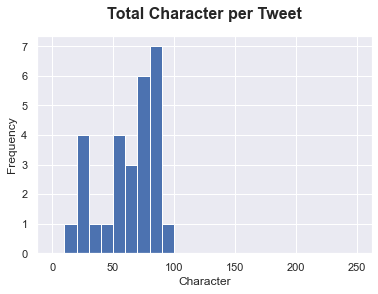

In [9]:
bin_range = np.arange(0, 260, 10)
df["Tweet_clean"].str.len().hist(bins=bin_range)
plt.title("Total Character per Tweet",
          fontweight="bold",
          size=16,
          y=1.05)
plt.xlabel("Character")
plt.ylabel("Frequency");

2. Total word frequency distribution in each tweet

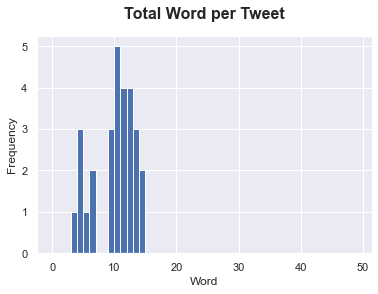

In [10]:
bin_range = np.arange(0, 50)
df["Tweet_clean"].str.split().map(lambda sentence: len(sentence)).hist(bins=bin_range)
plt.title("Total Word per Tweet",
          fontweight="bold",
          size=16,
          y=1.05)
plt.xlabel("Word")
plt.ylabel("Frequency");

3. Length of word frequency distribution in each tweet.

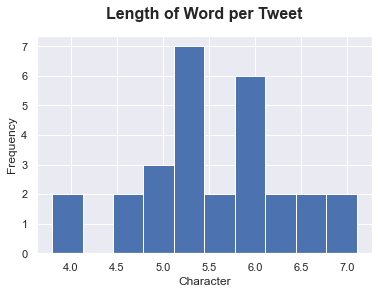

In [11]:
df["Tweet_clean"].str.split().apply(
    lambda sentence: [len(word) for word in sentence]).map(lambda x: np.mean(x)).hist()
plt.title("Length of Word per Tweet",
          fontweight="bold",
          size=16,
          y=1.05)
plt.xlabel("Character")
plt.ylabel("Frequency");

4. Most frequent words in all tweets.

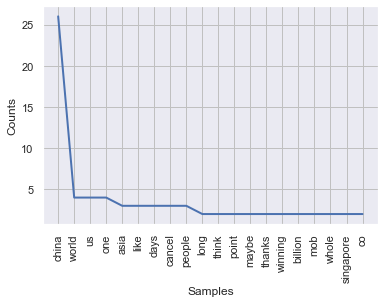

In [12]:
df_plot = df.copy()
df_plot["Tweet_clean"] = df_plot["Tweet_clean"].apply(lambda item: word_tokenize(str(item)))
text = [word for tweet in df_plot["Tweet_clean"] for word in tweet]

fqdist = FreqDist(text)
most_common_word = fqdist.most_common(20)
fqdist.plot(20, cumulative=False);   # show 20 most frequent words

##### N-gram Distribution

N-gram Distribution is a text analysis method that combines every n words to a single group. In this case, we use n = 2, also known as Bi-gram Distribution method.

In [13]:
tweet = [word for text in df["Tweet_clean"] for word in text.split()]
bi_gram = pd.Series(ngrams(tweet, 2)).value_counts()
bi_gram[:5]   # show first 10 group

(long, live)      1
(jessica, tan)    1
(china, days)     1
(days, cny)       1
(cny, pay)        1
dtype: int64

## Data Analysis

Based on the text analysis plot, insights that can be obtained from Singaporean tweets about China is the total character per tweet are around 70-80 characters. Then, each tweet consists of an average of 10-12 words where each word is composed of 5-6 characters. Furthermore, the 3 most frequent mentioned words in Singaporean tweets about China are "world", "US", and "one".

Based on the Bi-gram distribution analysis, insight that can be obtained is they talked mostly about Jessica Tan and Chinese New Year (CNY). This analysis result could be more reliable if more tweet data is used.